## Train a sparse semantic unet on patches from vessels gray scale image 

In this notebook we use the patches created in notebook ```21_Make_patches``` (which are generated from the labels in ```15_sparse_label```) as training data for a semantic segmentation unet. 

Imports:  Note on Linux for some reason we have to import and show Napari before importing PyTorch. 

In [1]:
import napari
viewer = napari.Viewer()

import numpy as np
import torch

from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from semantic_dataset import SemanticDataset
import random
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.utils.data import DataLoader
from semantic_helper import train
from monai.networks.nets import BasicUNet, UNet
from pathlib import Path
import os

c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check if Cuda is present

If cuda is not present training will be slow... 

In [2]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set Parent Path

This is the path that contains the images we will work with and pre-existing patches that would have been created in notebook ```21_Make_patches.ipynb```

In [3]:

#tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
tnia_images_path = Path(r"D:\images\tnia-python-images")
parent_path = tnia_images_path / "imagesc/2025_03_19_vessel_3D_lightsheet"

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Collect training data

Collect the training data that would have been created in ```33_label_semantic_sparse_rgb.ipynb```

In [4]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:429: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  input_img = io.imread(os.path.join(input_path, input_files[i]), plugin='tifffile')
c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:430: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  ground_truth_img = io.imread(os.path.join(truth_path, truth_files[i]), plugin='tifffile')
c:\users\bnort\work\i

Number of input images 1000
Number of ground truth images  1000
Size of first input image (512, 512)
Size of first ground truth image  (512, 512)


In [5]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 2, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))

Number of training images 998
Number of validaiton images  2


In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

X_test = X_val
Y_test = Y_val

X_train.shape, Y_train.shape

((998, 512, 512), (998, 512, 512))

In [7]:
Y_train = Y_train.astype(np.int16)-1
Y_test = Y_test.astype(np.int16)-1
Y_val = Y_val.astype(np.int16)-1

Y_train[Y_train==3] = 2
Y_test[Y_test==3] = 2
Y_val[Y_val==3] = 2

In [8]:
print(Y_train.min(), Y_train.max())
print(Y_test.min(), Y_test.max())
print(Y_val.min(), Y_val.max())

-1 2
-1 2
-1 2


## Preview Training Data

Just make sure it looks right and labels correspond to objects properly

int16
(512, 512) (512, 512)
0.08668218 0.89066696
float32 (512, 512) 0.08668218 0.89066696


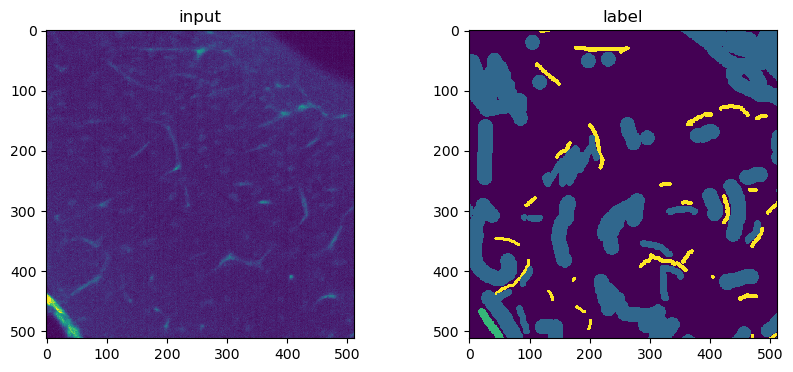

In [9]:
n=25
X_ = X_train[n]
Y_ = Y_train[n]
print(Y_.dtype)

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create Datasets

In [10]:
train_dataset = SemanticDataset(X_train, Y_train, crop_size=256)
test_dataset = SemanticDataset(X_val, Y_val, crop_size=256)
val_dataset = SemanticDataset(X_val, Y_val, crop_size=256)

# verify that the dataset is working
raw, mask = train_dataset[random.randrange(len(train_dataset))]
raw = np.transpose(raw, (1,2,0))
raw.shape,mask.shape

((512, 512, 1), (1, 512, 512))

## Visualize a few datasets

0 2
-1 2
0 2


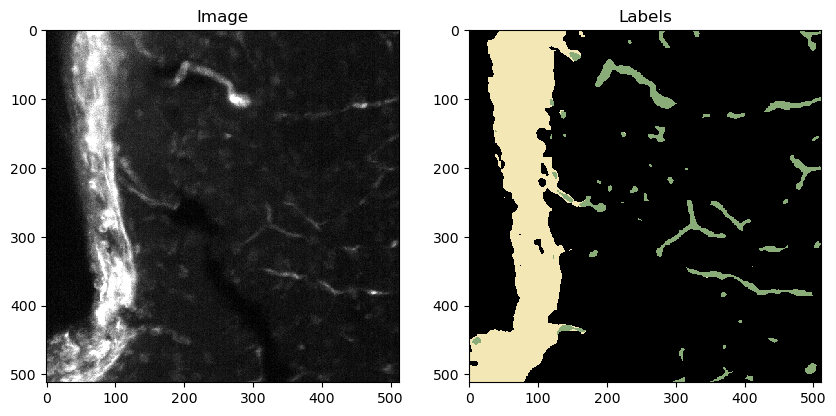

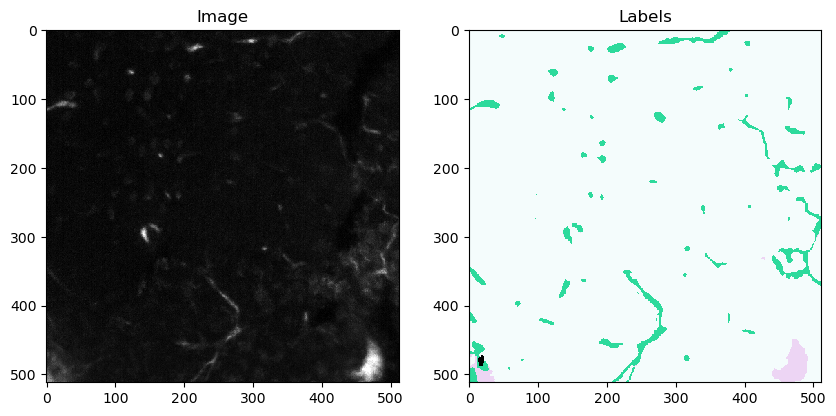

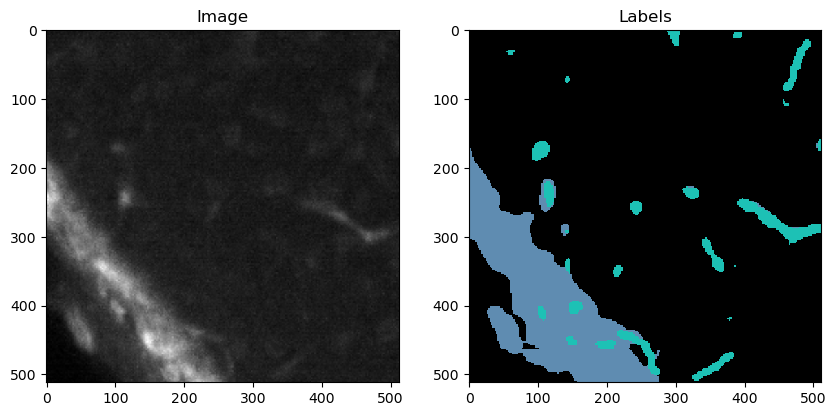

In [11]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

raw, mask = train_dataset[10]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

## Set up unet

We use monai BasicUnet.

Since image is RGB in_channels are 3

Since the dataset we are working with has 3 classes, out_channels are 3

No activation function since we are using CrossEntropyLoss which applies softmax
Note: predictor will need to use a softmax activation function



In [27]:
weights = torch.tensor([0.05, 0.2, 0.95]).float()
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1, weight=weights)
dtype = torch.LongTensor

'''
name = 'monai_basic_unet_mostly_defaults'

net = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=3,
    #features=[16, 16, 32, 64, 128, 16],
    act=None,
    norm="batch",
    #norm=None,
    #dropout=0.25,
)
'''

name = 'monai_unet_5_layers_2d'

net = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=3,
    channels=(32, 32, 64, 128, 256, 512),  # NO FINAL 32 in main UNet (it's for output later)
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,  # BasicUNet has no residual blocks
    act=("LeakyReLU", {"negative_slope": 0.01, "inplace": True}),
    norm="batch",
    dropout=0.0,
)


#net = torch.load( Path(model_path) / 'model_march22.pth')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

## Start training process

In [ ]:
train_batch_size = 16
test_batch_size = 1

learning_rate = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

training_steps = 500

train(train_loader, net, loss_fn, optimizer, dtype, 100, device)
#test_data_loader(train_loader, val_loader, net2, loss_fn, optimizer, dtype, 1, 100, device, writer)
#train(train_loader, val_loader, net2, loss_fn, None, optimizer, dtype, 10, device, writer)


torch.save(net, Path(model_path) / (name+'.pth'))

Epoch 0: 100%|██████████| 998/998 [00:06<00:00, 157.31it/s]


training loss at epoch 0 is 0.054784881865572115


Epoch 1: 100%|██████████| 998/998 [00:06<00:00, 162.20it/s]


training loss at epoch 1 is 0.0392496685883803


Epoch 2: 100%|██████████| 998/998 [00:06<00:00, 161.53it/s]


training loss at epoch 2 is 0.03288833295295616


Epoch 3: 100%|██████████| 998/998 [00:06<00:00, 159.45it/s]


training loss at epoch 3 is 0.028201784841522186


Epoch 4: 100%|██████████| 998/998 [00:06<00:00, 157.97it/s]


training loss at epoch 4 is 0.024329419096629463


Epoch 5: 100%|██████████| 998/998 [00:06<00:00, 158.56it/s]


training loss at epoch 5 is 0.022979996545998034


Epoch 6: 100%|██████████| 998/998 [00:06<00:00, 153.00it/s]


training loss at epoch 6 is 0.021159655420120826


Epoch 7: 100%|██████████| 998/998 [00:06<00:00, 157.07it/s]


training loss at epoch 7 is 0.019795084002619992


Epoch 8: 100%|██████████| 998/998 [00:06<00:00, 156.75it/s]


training loss at epoch 8 is 0.018487012428128887


Epoch 9: 100%|██████████| 998/998 [00:06<00:00, 150.21it/s]


training loss at epoch 9 is 0.018109380108918362


Epoch 10: 100%|██████████| 998/998 [00:06<00:00, 155.59it/s]


training loss at epoch 10 is 0.017214876929958742


Epoch 11: 100%|██████████| 998/998 [00:06<00:00, 145.25it/s]


training loss at epoch 11 is 0.01601286247402489


Epoch 12: 100%|██████████| 998/998 [00:06<00:00, 147.20it/s]


training loss at epoch 12 is 0.0162294283210634


Epoch 13: 100%|██████████| 998/998 [00:06<00:00, 151.37it/s]


training loss at epoch 13 is 0.015256131728569825


Epoch 14: 100%|██████████| 998/998 [00:06<00:00, 154.23it/s]


training loss at epoch 14 is 0.014938018469509477


Epoch 15: 100%|██████████| 998/998 [00:06<00:00, 152.27it/s]


training loss at epoch 15 is 0.01558201291219505


Epoch 16: 100%|██████████| 998/998 [00:06<00:00, 151.17it/s]


training loss at epoch 16 is 0.016187990185074913


Epoch 17: 100%|██████████| 998/998 [00:06<00:00, 148.49it/s]


training loss at epoch 17 is 0.01446608398744243


Epoch 18: 100%|██████████| 998/998 [00:06<00:00, 154.16it/s]


training loss at epoch 18 is 0.013910141715664185


Epoch 19: 100%|██████████| 998/998 [00:07<00:00, 140.84it/s]


training loss at epoch 19 is 0.013422509621761605


Epoch 20: 100%|██████████| 998/998 [00:06<00:00, 147.15it/s]


training loss at epoch 20 is 0.013024598539233925


Epoch 21: 100%|██████████| 998/998 [00:06<00:00, 147.59it/s]


training loss at epoch 21 is 0.012882683896468971


Epoch 22: 100%|██████████| 998/998 [00:06<00:00, 150.53it/s]


training loss at epoch 22 is 0.012072872258498816


Epoch 23: 100%|██████████| 998/998 [00:06<00:00, 151.24it/s]


training loss at epoch 23 is 0.011672591958530919


Epoch 24: 100%|██████████| 998/998 [00:06<00:00, 145.31it/s]


training loss at epoch 24 is 0.012502624897775287


Epoch 25: 100%|██████████| 998/998 [00:06<00:00, 154.16it/s]


training loss at epoch 25 is 0.011109474523810442


Epoch 26: 100%|██████████| 998/998 [00:06<00:00, 144.68it/s]


training loss at epoch 26 is 0.010292373478173732


Epoch 27: 100%|██████████| 998/998 [00:06<00:00, 148.84it/s]


training loss at epoch 27 is 0.01005186430945664


Epoch 28: 100%|██████████| 998/998 [00:06<00:00, 152.74it/s]


training loss at epoch 28 is 0.009749834838216911


Epoch 29: 100%|██████████| 998/998 [00:06<00:00, 147.61it/s]


training loss at epoch 29 is 0.00922020939076114


Epoch 30: 100%|██████████| 998/998 [00:06<00:00, 148.64it/s]


training loss at epoch 30 is 0.00924634354147978


Epoch 31: 100%|██████████| 998/998 [00:06<00:00, 151.86it/s]


training loss at epoch 31 is 0.00887303496291021


Epoch 32: 100%|██████████| 998/998 [00:06<00:00, 146.87it/s]


training loss at epoch 32 is 0.008465378759858125


Epoch 33: 100%|██████████| 998/998 [00:06<00:00, 144.32it/s]


training loss at epoch 33 is 0.008044551124792538


Epoch 34: 100%|██████████| 998/998 [00:06<00:00, 149.70it/s]


training loss at epoch 34 is 0.008021953260014673


Epoch 35: 100%|██████████| 998/998 [00:07<00:00, 142.23it/s]


training loss at epoch 35 is 0.007738326924418161


Epoch 36: 100%|██████████| 998/998 [00:06<00:00, 146.31it/s]


training loss at epoch 36 is 0.008939579435305031


Epoch 37: 100%|██████████| 998/998 [00:06<00:00, 152.72it/s]


training loss at epoch 37 is 0.007520288266316205


Epoch 38: 100%|██████████| 998/998 [00:06<00:00, 149.22it/s]


training loss at epoch 38 is 0.0068850458967303465


Epoch 39: 100%|██████████| 998/998 [00:06<00:00, 153.14it/s]


training loss at epoch 39 is 0.00646373775147484


Epoch 40: 100%|██████████| 998/998 [00:07<00:00, 142.35it/s]


training loss at epoch 40 is 0.006216939460329398


Epoch 41: 100%|██████████| 998/998 [00:06<00:00, 148.51it/s]


training loss at epoch 41 is 0.006405834004073917


Epoch 42: 100%|██████████| 998/998 [00:07<00:00, 141.76it/s]


training loss at epoch 42 is 0.006226477827242238


Epoch 43: 100%|██████████| 998/998 [00:06<00:00, 148.29it/s]


training loss at epoch 43 is 0.005932642934556476


Epoch 44: 100%|██████████| 998/998 [00:06<00:00, 150.64it/s]


training loss at epoch 44 is 0.005672407752735343


Epoch 45: 100%|██████████| 998/998 [00:06<00:00, 144.66it/s]


training loss at epoch 45 is 0.00530654599214484


Epoch 46: 100%|██████████| 998/998 [00:06<00:00, 149.11it/s]


training loss at epoch 46 is 0.0051286452429328035


Epoch 47: 100%|██████████| 998/998 [00:06<00:00, 145.63it/s]


training loss at epoch 47 is 0.005069332936394191


Epoch 48: 100%|██████████| 998/998 [00:06<00:00, 153.09it/s]


training loss at epoch 48 is 0.0051642792982484155


Epoch 49: 100%|██████████| 998/998 [00:07<00:00, 133.87it/s]


training loss at epoch 49 is 0.012733003770361443


Epoch 50: 100%|██████████| 998/998 [00:06<00:00, 151.12it/s]


training loss at epoch 50 is 0.010136268697007147


Epoch 51: 100%|██████████| 998/998 [00:07<00:00, 142.53it/s]


training loss at epoch 51 is 0.007117620327758168


Epoch 52: 100%|██████████| 998/998 [00:06<00:00, 145.16it/s]


training loss at epoch 52 is 0.005738482902009406


Epoch 53: 100%|██████████| 998/998 [00:06<00:00, 148.47it/s]


training loss at epoch 53 is 0.005100115543914463


Epoch 54: 100%|██████████| 998/998 [00:07<00:00, 136.06it/s]


training loss at epoch 54 is 0.004811202390548701


Epoch 55: 100%|██████████| 998/998 [00:06<00:00, 150.32it/s]


training loss at epoch 55 is 0.004658606082559348


Epoch 56: 100%|██████████| 998/998 [00:06<00:00, 145.14it/s]


training loss at epoch 56 is 0.0043390382245511476


Epoch 57: 100%|██████████| 998/998 [00:07<00:00, 141.86it/s]


training loss at epoch 57 is 0.004256186487978111


Epoch 58: 100%|██████████| 998/998 [00:06<00:00, 142.75it/s]


training loss at epoch 58 is 0.00502947084083108


Epoch 59: 100%|██████████| 998/998 [00:06<00:00, 144.99it/s]


training loss at epoch 59 is 0.004536704953483685


Epoch 60: 100%|██████████| 998/998 [00:07<00:00, 139.82it/s]


training loss at epoch 60 is 0.0041982905830971464


Epoch 61: 100%|██████████| 998/998 [00:06<00:00, 151.46it/s]


training loss at epoch 61 is 0.003932290848620788


Epoch 62: 100%|██████████| 998/998 [00:07<00:00, 140.00it/s]


training loss at epoch 62 is 0.0038749344781309905


Epoch 63: 100%|██████████| 998/998 [00:06<00:00, 147.81it/s]


training loss at epoch 63 is 0.005602959722638847


Epoch 64: 100%|██████████| 998/998 [00:07<00:00, 140.25it/s]


training loss at epoch 64 is 0.005077699960801071


Epoch 65: 100%|██████████| 998/998 [00:06<00:00, 149.09it/s]


training loss at epoch 65 is 0.004003036250257659


Epoch 66: 100%|██████████| 998/998 [00:06<00:00, 151.19it/s]


training loss at epoch 66 is 0.0037759294311603708


Epoch 67: 100%|██████████| 998/998 [00:07<00:00, 140.06it/s]


training loss at epoch 67 is 0.003668355455021103


Epoch 68: 100%|██████████| 998/998 [00:06<00:00, 145.42it/s]


training loss at epoch 68 is 0.0035643682092846274


Epoch 69: 100%|██████████| 998/998 [00:06<00:00, 142.86it/s]


training loss at epoch 69 is 0.003697808133904824


Epoch 70: 100%|██████████| 998/998 [00:07<00:00, 140.48it/s]


training loss at epoch 70 is 0.014100221024904557


Epoch 71: 100%|██████████| 998/998 [00:06<00:00, 145.29it/s]


training loss at epoch 71 is 0.008060018306146404


Epoch 72: 100%|██████████| 998/998 [00:06<00:00, 147.44it/s]


training loss at epoch 72 is 0.0065488642033092485


Epoch 73: 100%|██████████| 998/998 [00:07<00:00, 142.02it/s]


training loss at epoch 73 is 0.004851134180395541


Epoch 74: 100%|██████████| 998/998 [00:06<00:00, 143.76it/s]


training loss at epoch 74 is 0.004211907052922106


Epoch 75: 100%|██████████| 998/998 [00:06<00:00, 147.24it/s]


training loss at epoch 75 is 0.003856126498990881


Epoch 76: 100%|██████████| 998/998 [00:07<00:00, 139.82it/s]


training loss at epoch 76 is 0.003760689249885584


Epoch 77: 100%|██████████| 998/998 [00:07<00:00, 138.46it/s]


training loss at epoch 77 is 0.0035638790241702047


Epoch 78: 100%|██████████| 998/998 [00:06<00:00, 150.64it/s]


training loss at epoch 78 is 0.0034047974430338177


Epoch 79: 100%|██████████| 998/998 [00:06<00:00, 148.91it/s]


training loss at epoch 79 is 0.0033219157492290277


Epoch 80: 100%|██████████| 998/998 [00:06<00:00, 150.57it/s]


training loss at epoch 80 is 0.0032466863970718306


Epoch 81: 100%|██████████| 998/998 [00:06<00:00, 150.08it/s]


training loss at epoch 81 is 0.0031507342087033993


Epoch 82: 100%|██████████| 998/998 [00:06<00:00, 149.09it/s]


training loss at epoch 82 is 0.0031543710513529414


Epoch 83: 100%|██████████| 998/998 [00:06<00:00, 147.68it/s]


training loss at epoch 83 is 0.003078482287351736


Epoch 84: 100%|██████████| 998/998 [00:06<00:00, 153.37it/s]


training loss at epoch 84 is 0.0031579223970970315


Epoch 85: 100%|██████████| 998/998 [00:06<00:00, 148.34it/s]


training loss at epoch 85 is 0.0030898908750417236


Epoch 86: 100%|██████████| 998/998 [00:06<00:00, 151.81it/s]


training loss at epoch 86 is 0.002927334004927255


Epoch 87: 100%|██████████| 998/998 [00:07<00:00, 139.64it/s]


training loss at epoch 87 is 0.002889067311593908


Epoch 88: 100%|██████████| 998/998 [00:07<00:00, 141.08it/s]


training loss at epoch 88 is 0.0028320567715980245


Epoch 89: 100%|██████████| 998/998 [00:06<00:00, 152.34it/s]


training loss at epoch 89 is 0.002754482520904713


Epoch 90: 100%|██████████| 998/998 [00:06<00:00, 148.23it/s]


training loss at epoch 90 is 0.0032011310855497815


Epoch 91: 100%|██████████| 998/998 [00:06<00:00, 142.80it/s]


training loss at epoch 91 is 0.003360978165316677


Epoch 92: 100%|██████████| 998/998 [00:07<00:00, 142.42it/s]


training loss at epoch 92 is 0.004196323305069803


Epoch 93: 100%|██████████| 998/998 [00:07<00:00, 141.53it/s]


training loss at epoch 93 is 0.00310486128632136


Epoch 94: 100%|██████████| 998/998 [00:06<00:00, 149.24it/s]


training loss at epoch 94 is 0.0028956322454826867


Epoch 95: 100%|██████████| 998/998 [00:07<00:00, 142.27it/s]


training loss at epoch 95 is 0.0027994973947086887


Epoch 96: 100%|██████████| 998/998 [00:06<00:00, 144.05it/s]


training loss at epoch 96 is 0.002714218571782112


Epoch 97: 100%|██████████| 998/998 [00:06<00:00, 147.91it/s]


training loss at epoch 97 is 0.002554698197734738


Epoch 98: 100%|██████████| 998/998 [00:06<00:00, 144.78it/s]


training loss at epoch 98 is 0.002536050281030143


Epoch 99: 100%|██████████| 998/998 [00:06<00:00, 147.45it/s]

training loss at epoch 99 is 0.0026754199700777183


## Test predictions

torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)


c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\plotting\plt_helper.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(rows, cols, figsize=(width,height))


torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)
torch.Size([1, 3, 512, 512]) (1, 512, 512)


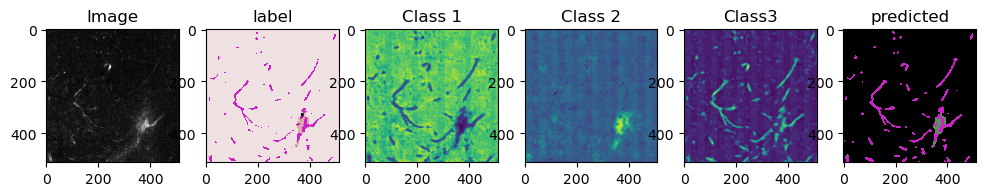

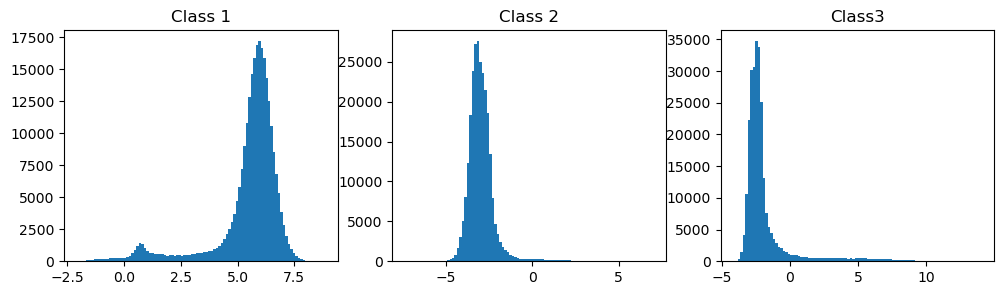

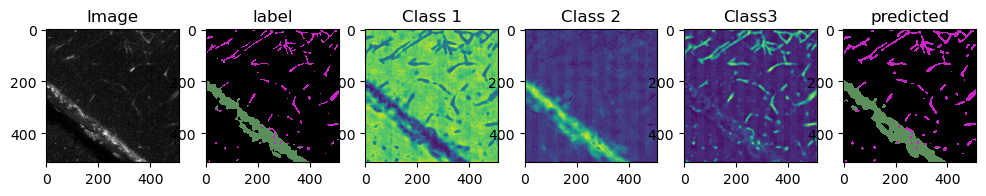

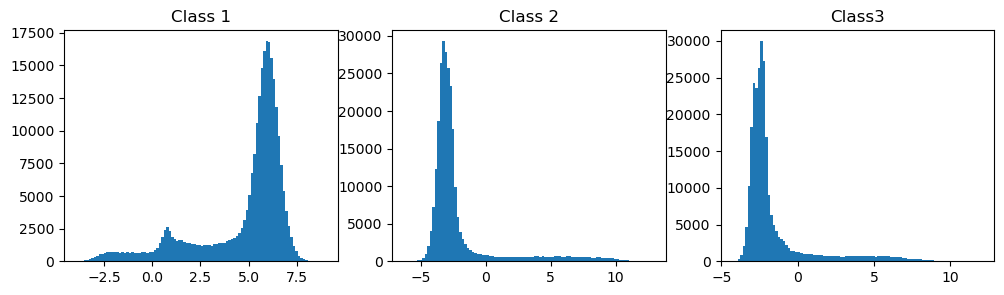

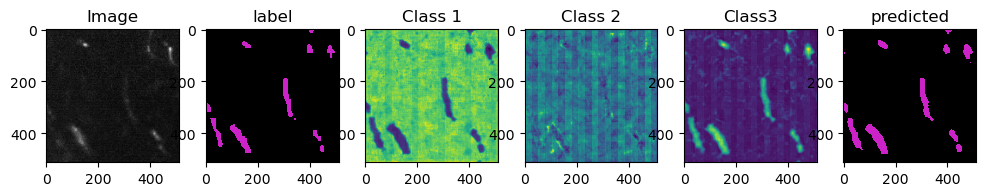

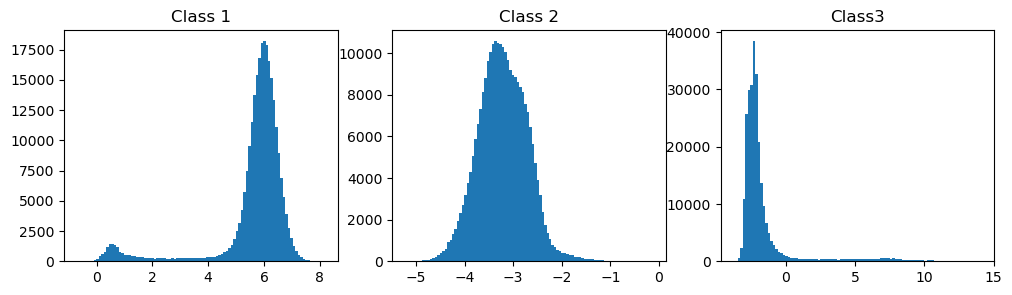

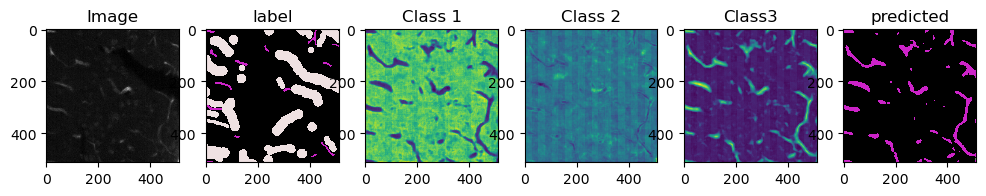

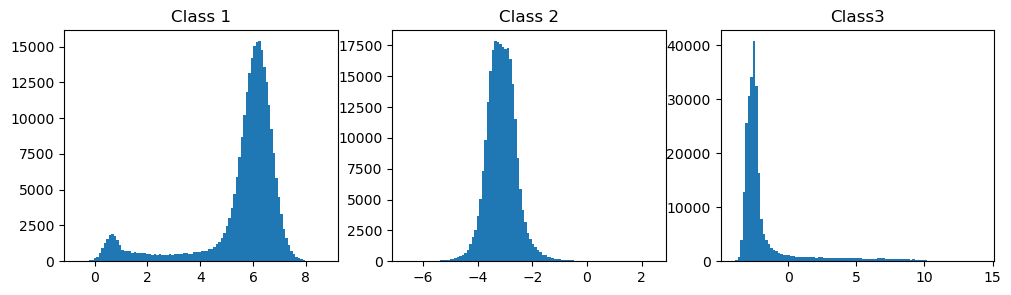

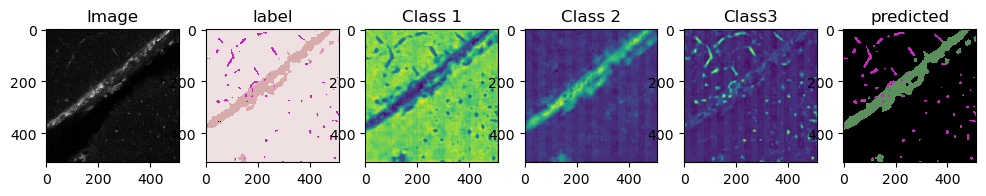

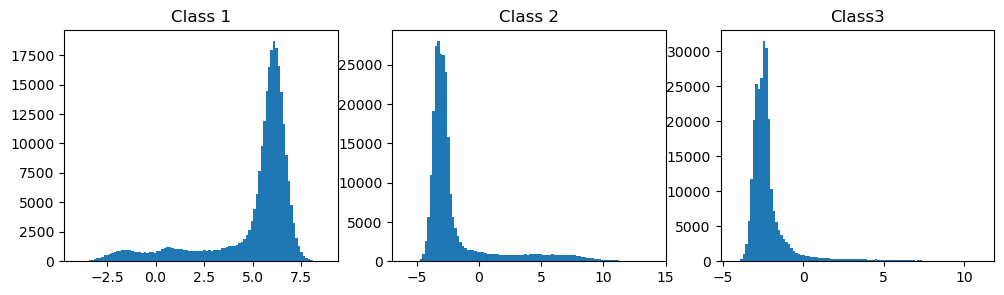

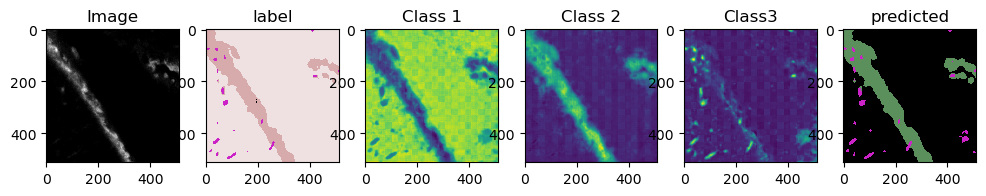

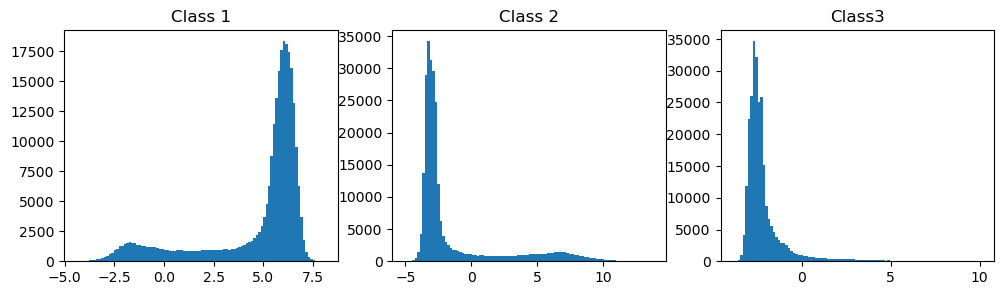

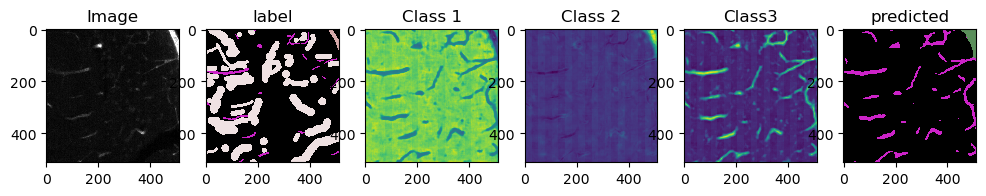

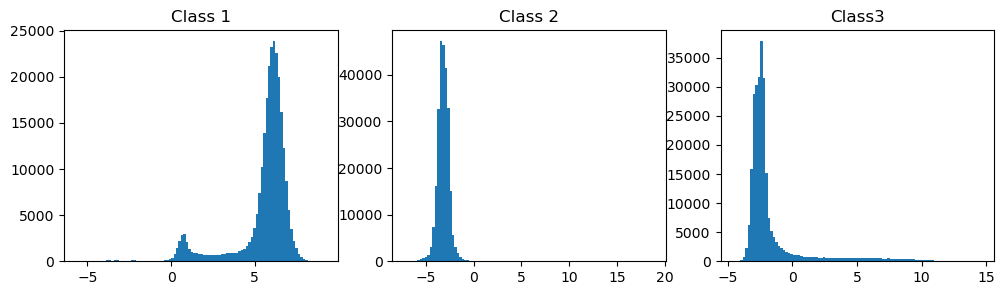

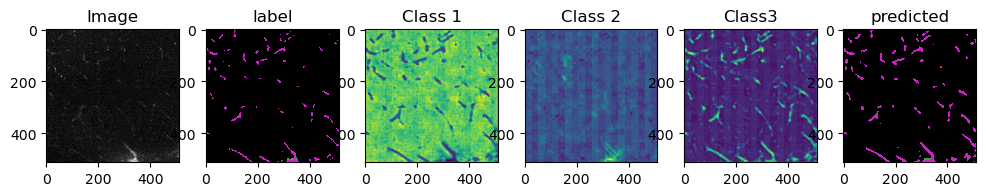

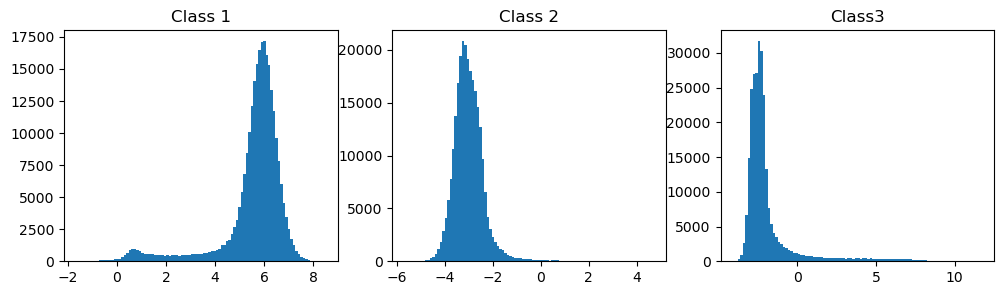

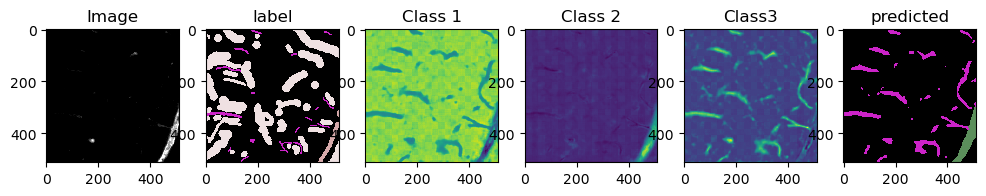

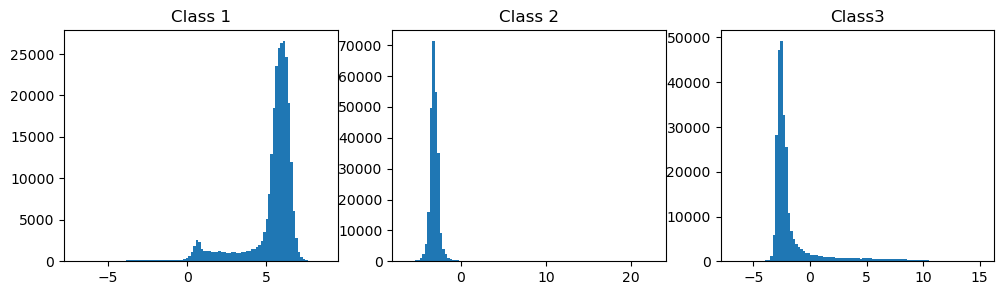

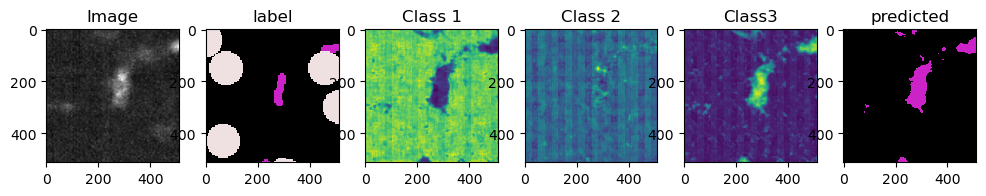

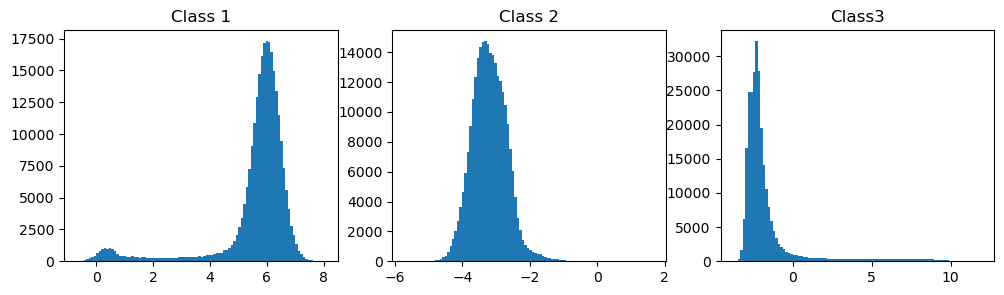

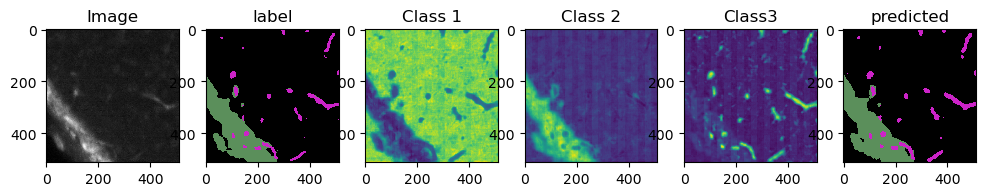

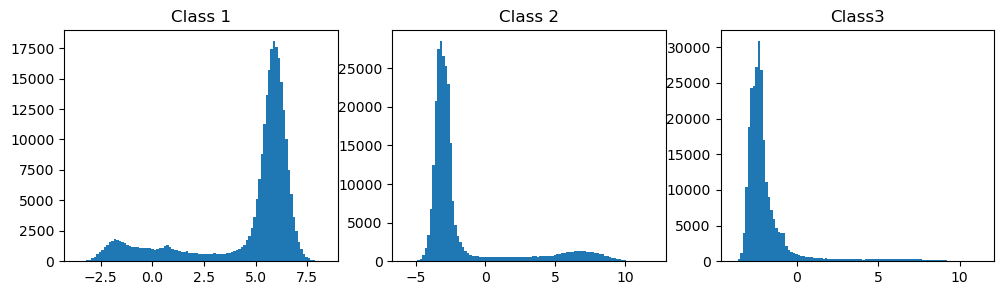

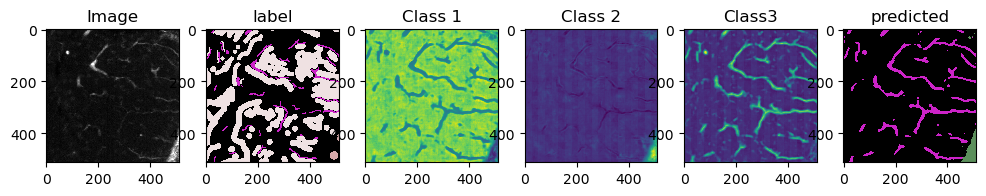

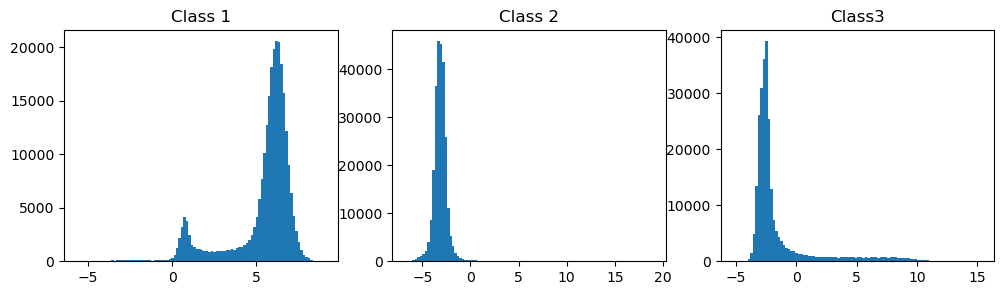

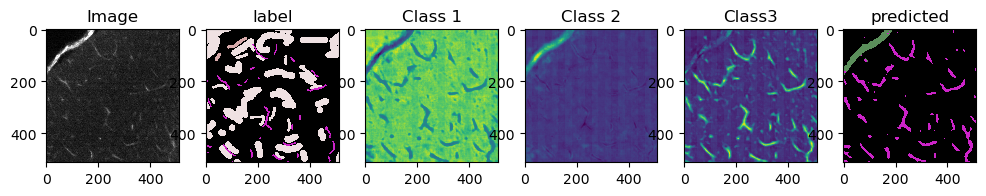

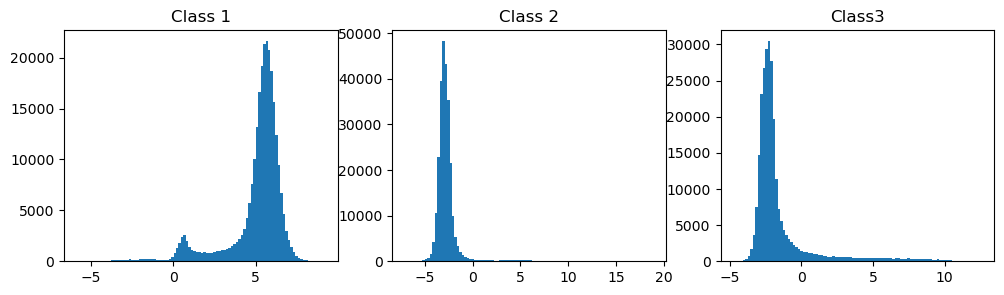

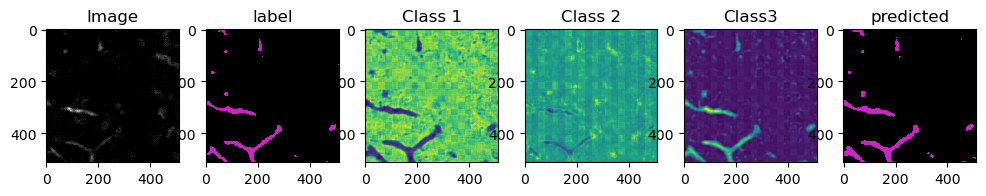

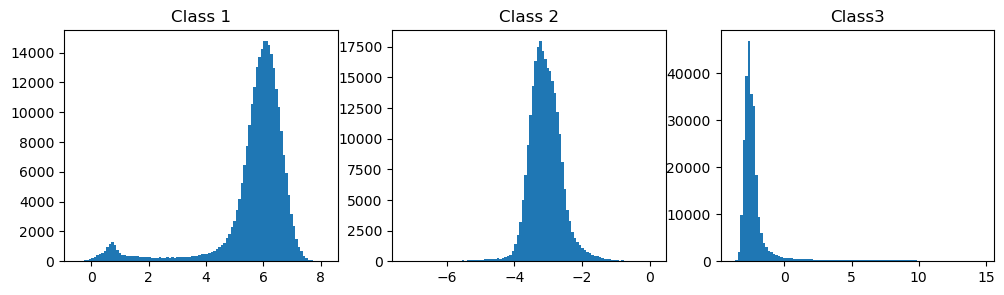

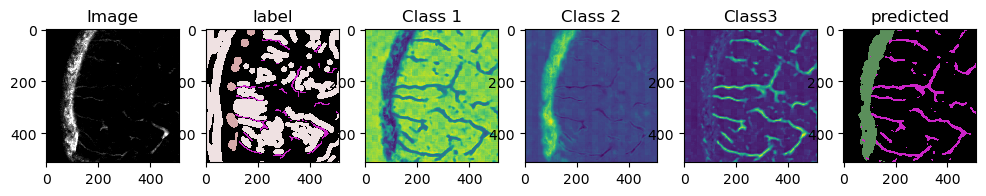

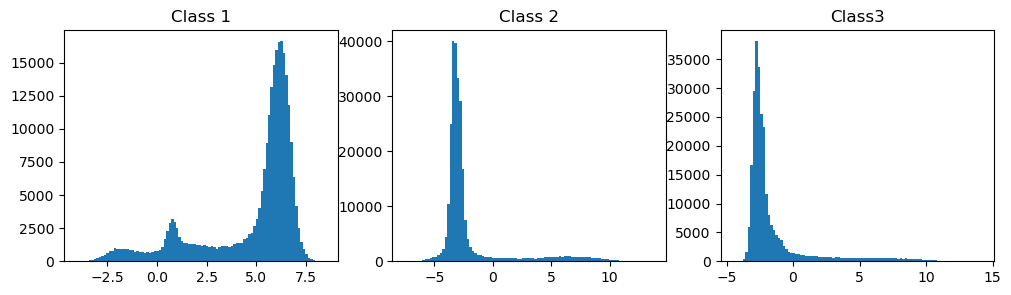

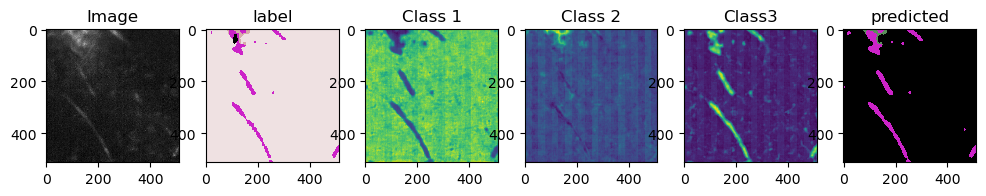

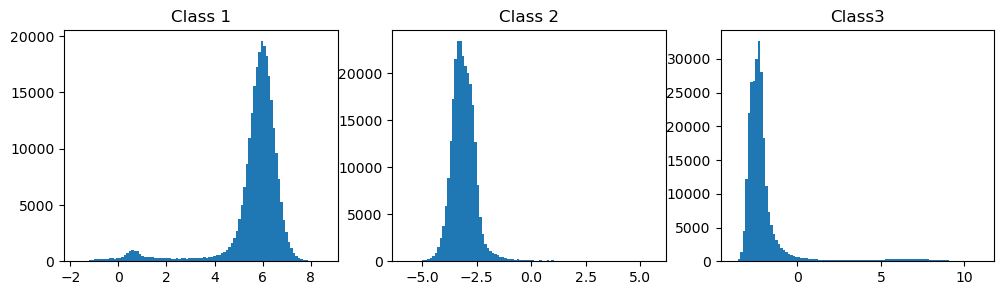

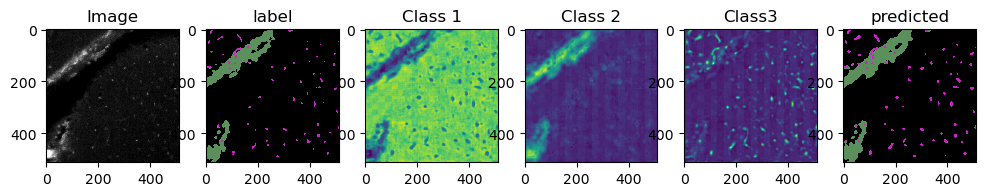

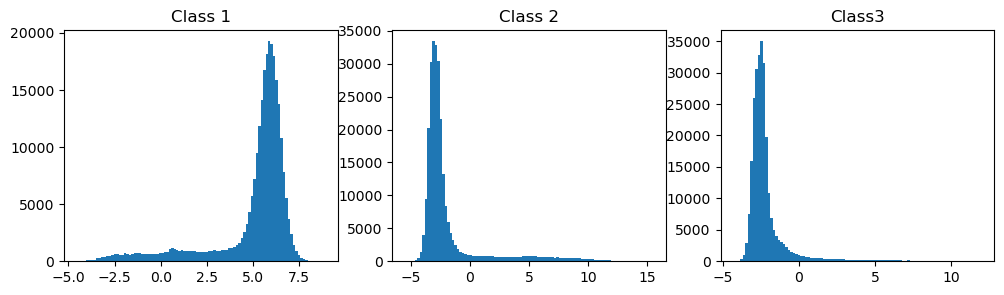

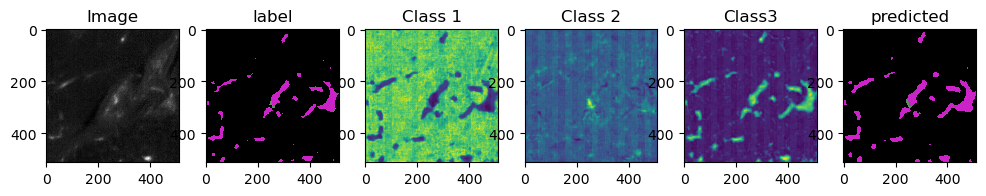

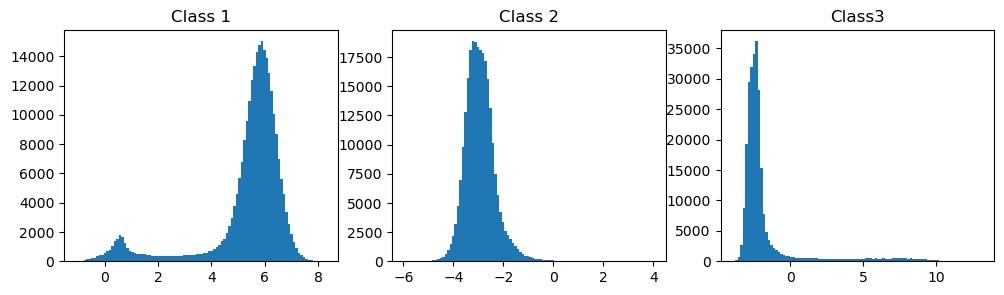

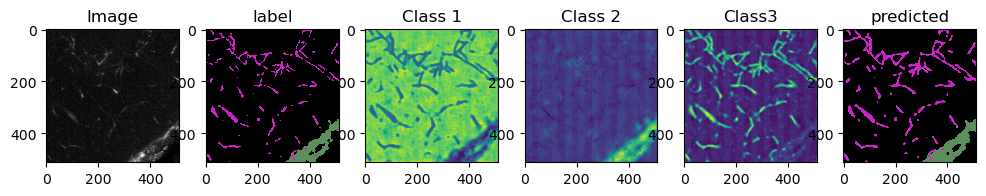

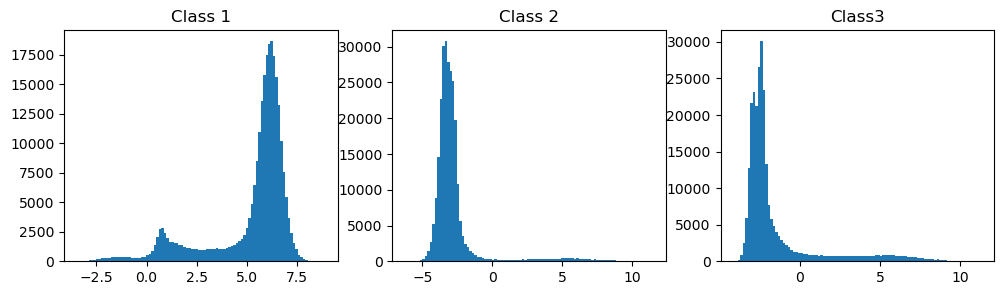

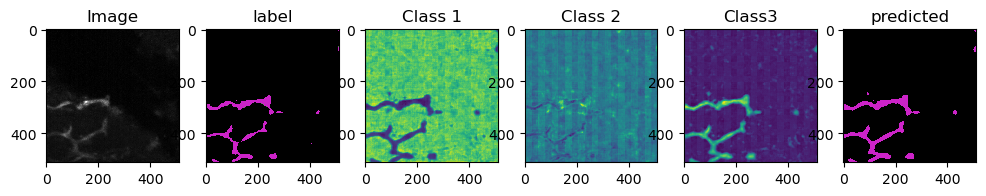

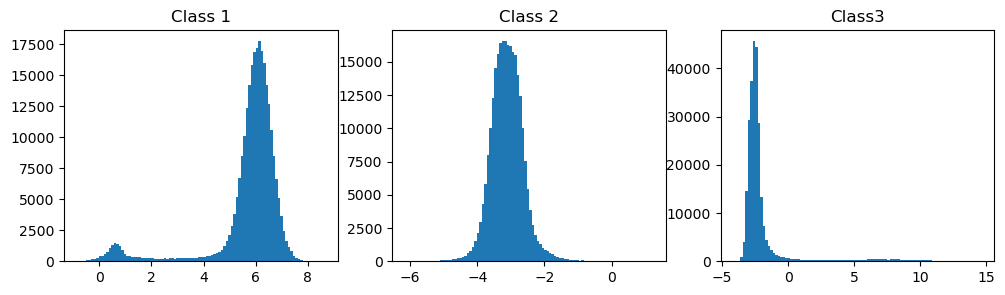

In [29]:

import torch.nn.functional as F

rlcm = random_label_cmap()

for i in range(20):
    #features, label = train_loader.dataset[random.randrange(len(train_loader.dataset))]
    features, label = train_loader.dataset[i]
    
    net.eval()
    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)       
    #features = features.todevice()
    predicted = net(features_tensor)

    print(predicted.shape, features.shape)

    features = np.transpose(features, (1,2,0))

    predicted.shape
    c1 = predicted[0,0,:,:].cpu().detach().numpy()
    c2 = predicted[0,1,:,:].cpu().detach().numpy()
    c3 = predicted[0,2,:,:].cpu().detach().numpy()

    # Apply softmax along the class dimension (dim=1)
    probabilities = F.softmax(predicted, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1).cpu().detach().numpy()
    
    fig = imshow_multi2d([features, label, c1, c2, c3, predicted_classes], ['Image', 'label', 'Class 1', 'Class 2', 'Class3', 'predicted'], 1, 6, 12, 12,colormaps=['gray', rlcm, 'viridis', 'viridis', 'viridis', rlcm])
    fig = imshow_multi2d([c1, c2, c3], ['Class 1', 'Class 2', 'Class3'], 1, 3, 12, 3,colormaps=['gray', 'gray', 'gray'], plottypes=['hist', 'hist', 'hist'])